<table align="center">
  <a target="_blank" href="https://colab.research.google.com/github/martinlf6/schwab-ds-takehome-FengLiu/blob/main/03_models.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>
</table>

In [26]:
!pip install datasets==3.6.0 --force-reinstall


  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-21.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using ca

In [1]:
# Load packages
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import pandas as pd


In [2]:
# Load dataset
ds = load_dataset("financial_phrasebank", "sentences_allagree") # 'sentences_allagree' means only sentences where all annotators agreed on the sentiment label are included in the loaded dataset. ds is now a DatasetDict object with splits like "train"
df = ds["train"].to_pandas().rename(columns={"sentence":"text","label":"y"}) # Convert to Pandas dataframe. ds["train"] selects the training split of the dataset
label_map = {0: "negative", 1: "neutral", 2: "positive"} # Create a mapping from numbers to labels
df["label"] = df["y"].map(label_map) # Apply the mapping: replaces each numeric value in column y with its text label and creates a new column label with human-readable sentiment.
df["len"] = df["text"].str.split().apply(len) # .split() splits each list in text column (sentence) on whitespace, another word, splits each sentence into words. apply(len) applies the built-in Python len() function to each list in text column (sentence) that gives the number of words in the sentence.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df

,text,y,label,len
0,"According to Gran , the company has no plans t...",1,neutral,25
1,"For the last quarter of 2010 , Componenta 's n...",2,positive,39
2,"In the third quarter of 2010 , net sales incre...",2,positive,29
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,positive,24
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,positive,22
...,...,...,...,...
2259,Operating result for the 12-month period decre...,0,negative,27
2260,HELSINKI Thomson Financial - Shares in Cargote...,0,negative,40
2261,LONDON MarketWatch -- Share prices ended lower...,0,negative,26
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0,negative,23


In [4]:
# Install spaCy and python -m in order to load the spaCy transformer model, en_core_web_trf.
!pip install spacy
!python -m spacy download en_core_web_trf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 1.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
import spacy
nlp = spacy.load("en_core_web_trf") # Load spaCy transformer model, en_core_web_trf, for aspect identification.


In [6]:
# Create an aspect-level dataset by transforming the sentence-level dataset using spaCy transformer model, en_core_web_trf.
# Aspects: organizations, products (e.g., “ETF” (Exchange-Traded Fund), “credit card”, “mobile app”), key financial facets (“revenue”, “guidance”, “fees”).)

# Define aspect extraction function
def extract_aspects(text):
    doc = nlp(text) # Runs the input text through spaCy’s NLP pipeline that will produce a Doc object with tokens, entities, and noun chunks.
    aspects = [] # Initializes an empty list aspects to store extracted phrases.

    # Named entities of interest
    for ent in doc.ents: # Loops through recognized named entities (doc.ents).
        if ent.label_ in {"ORG","PRODUCT","WORK_OF_ART"}:  # Keeps only those labeled as: "ORG", "PRODUCT" (products such as iPhone and Coca-Cola), and "WORK_OF_ART" (titles, works, etc.). Extend if needed.
            aspects.append(ent.text) # Add the text to the aspects list.

    # Extract financial noun chunks for financial facets
    for nc in doc.noun_chunks: # Iterates over noun phrases (e.g., "the quarterly revenue", "profit margin")
        head = nc.root.lemma_.lower() # Gets the root word’s lemma (base form)
        if head in {"revenue","guidance","dividend","yield","fees","costs","margin","outlook","results","stock","shares"}: # If the root is one of the predefined financial terms (like "revenue", "margin", "stock", etc.), it’s considered an aspect.
            aspects.append(nc.text) # Adds the entire chunk (nc.text) to aspects.

    # Deduplicate results: returns a cleaned list of aspects.
    aspects = list(dict.fromkeys(a.strip() for a in aspects if len(a.strip())>1)) # a.strip(): removes leading/trailing whitespace. len(a.strip())>1: ignores meaningless single-character tokens. dict.fromkeys(...): removes duplicates while preserving order.
    return aspects

df["aspects"] = df["text"].apply(extract_aspects) # Creates a new column aspects containing a list of extracted aspects for each sentence.
df["num_aspects"] = df["aspects"].str.len() # Creates another column num_aspects with the number of aspects found.
print(df[["text","aspects"]].head(10))

# Transform the sentence-level dataset into an aspect-level dataset
pairs = []
for _, row in df.iterrows(): # Loops through the DataFrame df row by row.
    s = row["text"]; sent_label = row["label"]; aspects = row["aspects"] # s: the sentence text. sent_label: sentiment label (negative/neutral/positive). aspects: list of extracted aspects from the sentence.
    if not aspects: # Skip sentences with no aspects (the sentence with no aspects is not useful for aspect-level analysis)
        continue
    if len(aspects) == 1:
        pairs.append({"sentence": s, "aspect": aspects[0], "label": sent_label}) # If there’s exactly 1 aspect, create a dictionary with: "sentence" as full sentence text, "aspect" as the only aspect, and "label" as the sentence-level sentiment; and append it to pairs.
    else:
        # If there are multiple aspects in the same sentence: It duplicates the sentence into multiple rows, one for each aspect. Assigns the same sentence-level sentiment to each aspect (this is a simplification; in reality, some aspects might be positive while others are negative).
        for a in aspects:
            pairs.append({"sentence": s, "aspect": a, "label": sent_label})

pairs_df = pd.DataFrame(pairs) # Convert to DataFrame, and now each row = one aspect, instead of one sentence.
print(pairs_df.head())


                                                text  \
0  According to Gran , the company has no plans t...   
1  For the last quarter of 2010 , Componenta 's n...   
2  In the third quarter of 2010 , net sales incre...   
3  Operating profit rose to EUR 13.1 mn from EUR ...   
4  Operating profit totalled EUR 21.1 mn , up fro...   
5  Finnish Talentum reports its operating profit ...   
6  Clothing retail chain Sepp+ñl+ñ 's sales incre...   
7  Consolidated net sales increased 16 % to reach...   
8  Foundries division reports its sales increased...   
9  HELSINKI ( AFX ) - Shares closed higher , led ...   

                             aspects  
0                                 []  
1                       [Componenta]  
2                                 []  
3                                 []  
4                                 []  
5                 [Finnish Talentum]  
6                        [Sepp+ñl+ñ]  
7                                 []  
8          [Foundries, Machine S

In [7]:
df

,text,y,label,len,aspects,num_aspects
0,"According to Gran , the company has no plans t...",1,neutral,25,[],0
1,"For the last quarter of 2010 , Componenta 's n...",2,positive,39,[Componenta],1
2,"In the third quarter of 2010 , net sales incre...",2,positive,29,[],0
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,positive,24,[],0
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,positive,22,[],0
...,...,...,...,...,...,...
2259,Operating result for the 12-month period decre...,0,negative,27,[],0
2260,HELSINKI Thomson Financial - Shares in Cargote...,0,negative,40,"[HELSINKI Thomson Financial, Cargotec]",2
2261,LONDON MarketWatch -- Share prices ended lower...,0,negative,26,"[MarketWatch, bank stocks]",2
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0,negative,23,[],0


In [16]:
#######################################################################################
# A) Sentence-Level Sentiment Classification (using sentence-level dataset)
#######################################################################################
# Split into train / test (80/20), stratified by label (balanced) ensuring that the proportion of each class (or label) is maintained in both subsets.
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["y"])
# Further split train into train / validation (90/10 of the 80%)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df["y"])


In [18]:
df

,text,y,label,len,aspects,num_aspects
0,"According to Gran , the company has no plans t...",1,neutral,25,[],0
1,"For the last quarter of 2010 , Componenta 's n...",2,positive,39,[Componenta],1
2,"In the third quarter of 2010 , net sales incre...",2,positive,29,[],0
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,positive,24,[],0
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,positive,22,[],0
...,...,...,...,...,...,...
2259,Operating result for the 12-month period decre...,0,negative,27,[],0
2260,HELSINKI Thomson Financial - Shares in Cargote...,0,negative,40,"[HELSINKI Thomson Financial, Cargotec]",2
2261,LONDON MarketWatch -- Share prices ended lower...,0,negative,26,"[MarketWatch, bank stocks]",2
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0,negative,23,[],0


In [19]:
# Tokenization
MODEL_NAME = "ProsusAI/finbert"   # Loads FinBERT, a BERT model pre-trained on financial texts.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # Load the Tokenizer that will convert raw text (words/sentences) into numeric IDs that the model understands: input_ids (integer IDs) representing tokens and attention_mask (1s and 0s) showing which tokens are real vs. padding.

# Tokenizes sentences into IDs the model can process.
train_encodings = tokenizer(list(train_df["text"]), truncation=True, padding=True, max_length=128) # Truncation and padding guarantee that every input has exactly 128 tokens.
val_encodings   = tokenizer(list(val_df["text"]), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_df["text"]), truncation=True, padding=True, max_length=128)


In [20]:
# Convert to TensorFlow Dataset with each element as a tuple: Inputs (dict(train_encodings)) and Labels (np.array(train_labels)).
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    np.array(train_df["y"])
)).shuffle(1000).batch(16) # Randomly shuffles the training dataset with a buffer size of 1000 samples to prevent the model from just memorizing the order of the data. Groups 16 samples per batch for training, which speeds up learning and makes gradients more stable.

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    np.array(val_df["y"])
)).batch(32) # Use a bigger batch size (32) since no backpropagate during validation with a lower memory usage.

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    np.array(test_df["y"])
)).batch(32)


In [21]:
# Take a look at the first element of the validation dataset
for element in val_dataset.take(1):
    print(element)

({'input_ids': <tf.Tensor: shape=(32, 93), dtype=int32, numpy=
array([[  101,  1006,  4748, ...,     0,     0,     0],
       [  101,  2077, 17710, ...,     0,     0,     0],
       [  101,  1996,  2512, ...,     0,     0,     0],
       ...,
       [  101,  1006,  4748, ...,     0,     0,     0],
       [  101,  4748,  2361, ...,     0,     0,     0],
       [  101,  1017,  2254, ...,  5958,  1012,   102]],
      shape=(32, 93), dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(32, 93), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(32, 93), dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32, 93), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 

In [25]:
# Loads FinBERT as a TensorFlow model with a classification head (3 classes)
model = TFAutoModelForSequenceClassification.from_pretrained(  # Output class predictions instead of just embeddings
    MODEL_NAME,
    num_labels=3, # Defines the number of output classes (3: negative, neutral, positive sentiment). The model will output a vector of length 3 for each input (e.g., [0.1, 0.7, 0.2] for probabilities).
    id2label={0:"negative",1:"neutral",2:"positive"},
    label2id={"negative":0,"neutral":1,"positive":2} # Map between numbers and human-friendly labels.
)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Check sentiment distribution and see whether need to address imbalance during model trainning.
print(df["label"].value_counts())


label
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


In [ ]:
# Not run this cell with the imbalanced data
# Compile the Model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5) # Optimizer: Adam with small learning rate (standard for BERT fine-tuning and too large a learning rate will destroy pre-trained weights). Fine-tuning usually uses values between 2e-5 and 5e-5.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # Loss: SparseCategoricalCrossentropy (used for multi-class classification when labels are integers, not one-hot (e.g., negative: [1, 0, 0], neutral: [0, 1, 0])).
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train & evaluate
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3) # The dataset will be passed through the model 3 times, and history stores a training log with metrics and loss over time.
results = model.evaluate(test_dataset) # Run the trained model on the test dataset and returns a list: [loss, accuracy] (since the model is compiled with loss + accuracy).
print("Test set results:", results)

In [36]:
# Use the weighting approach to adjust the loss function to penalize misclassifications of minority classes more heavily to address imbalance.
class_counts = np.bincount(train_df["y"])
total_samples = len(train_df["y"])
num_classes = len(class_counts)
class_weights = {}
for i, count in enumerate(class_counts): # Use inverse weighting
   class_weights[i] = total_samples / (num_classes * count)

# Define weighted loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def weighted_loss(y_true, y_pred):
    # y_true: true labels (batch)
    # y_pred: predicted logits (batch, num_classes)
    y_true = tf.cast(y_true, tf.int32) # Ensures labels are integers
    weights = tf.gather([class_weights[0], class_weights[1], class_weights[2]], y_true) # Lookup weights per class, and make mistakes on minority classes more costly.
    unweighted_loss = loss_fn(y_true, y_pred) # Compute base loss
    return tf.reduce_mean(unweighted_loss * weights) # Average batch loss and each sample’s loss is scaled by its class weight.

# Compile the Model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss=weighted_loss, metrics=["accuracy"])

# Train with validation
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)
# Evaluate on test set
results = model.evaluate(test_dataset)
print("\nTest set results:", results)


Epoch 1/3
102/102 [==============================] - 2953s 29s/step - loss: 0.2534 - accuracy: 0.9626 - val_loss: 0.0875 - val_accuracy: 0.9780
Epoch 2/3
102/102 [==============================] - 2622s 26s/step - loss: 0.0588 - accuracy: 0.9871 - val_loss: 0.0464 - val_accuracy: 0.9890
Epoch 3/3
15/15 [==============================] - 144s 9s/step - loss: 0.0953 - accuracy: 0.9757

Test set results: [0.0953376516699791, 0.9757174253463745]


15/15 [==============================] - 220s 14s/step
              precision    recall  f1-score   support

    negative       0.98      0.92      0.95        61
     neutral       1.00      0.99      0.99       278
    positive       0.93      0.98      0.95       114

    accuracy                           0.98       453
   macro avg       0.97      0.96      0.96       453
weighted avg       0.98      0.98      0.98       453



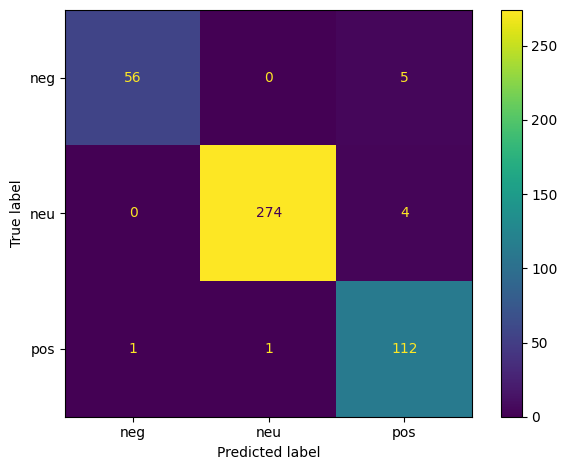

In [37]:
# Get detailed classification report (precision, recall, F1, and confusion matrix)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on test set
logits = model.predict(test_dataset).logits # Run the model on the test dataset and output the logits.
preds = np.argmax(logits, axis=-1) # Convert logits to predicted labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0) # Ground-truth class IDs from the test dataset.

# Report
print(classification_report(true_labels, preds, target_names=["negative","neutral","positive"]))

# Confusion matrix
cm = confusion_matrix(true_labels, preds)
ConfusionMatrixDisplay(cm, display_labels=["neg","neu","pos"]).plot()
plt.tight_layout()
plt.show()


In [38]:
#######################################################################################
# B) Aspect-Level Sentiment Classification (using the aspect-level dataset, pairs_df)
#######################################################################################
# Unlike general sentiment analysis (classify the whole sentence), here we analyze sentiment toward a specific aspect in the sentence.
# Example:
# Sentence: "The food was great but the service was terrible."
# Aspect: "food"     → label = positive
# Aspect: "service"  → label = negative

# Encode labels. Add a numeric label_id column (0: negative, 1: neutral, 2: positive) to the dataset.
labels = ["negative","neutral","positive"]
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
pairs_df["label_id"] = pairs_df["label"].map(label2id)


In [39]:
pairs_df

,sentence,aspect,label,label_id
0,"For the last quarter of 2010 , Componenta 's n...",Componenta,positive,2
1,Finnish Talentum reports its operating profit ...,Finnish Talentum,positive,2
2,Clothing retail chain Sepp+ñl+ñ 's sales incre...,Sepp+ñl+ñ,positive,2
3,Foundries division reports its sales increased...,Foundries,positive,2
4,Foundries division reports its sales increased...,Machine Shop,positive,2
...,...,...,...,...
2003,"Operating profits in the half were 0.8 m , do...",Glisten,negative,0
2004,HELSINKI Thomson Financial - Shares in Cargote...,HELSINKI Thomson Financial,negative,0
2005,HELSINKI Thomson Financial - Shares in Cargote...,Cargotec,negative,0
2006,LONDON MarketWatch -- Share prices ended lower...,MarketWatch,negative,0


In [40]:
# Train/val/test split
train_df, test_df = train_test_split(pairs_df, test_size=0.2, random_state=42, stratify=pairs_df["label_id"])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df["label_id"])


In [41]:
# Tokenize as (sentence, aspect) pairs and convert to TF Datasets
train_enc = tokenizer(list(train_df["sentence"]), list(train_df["aspect"]), # Take two sequences: Sentence (context) and Aspect (the target entity/feature), and combine them.
                      truncation=True, padding=True, max_length=160) # The output (e.g., train_enc) contains: input_ids (token IDs), attention_mask (1 for real tokens, 0 for padding), and token_type_ids (segment IDs (distinguish sentence vs aspect)).
val_enc   = tokenizer(list(val_df["sentence"]), list(val_df["aspect"]),
                      truncation=True, padding=True, max_length=160)
test_enc   = tokenizer(list(test_df["sentence"]), list(test_df["aspect"]),
                      truncation=True, padding=True, max_length=160)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_enc),
    np.array(train_df["label_id"])
)).shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_enc),
    np.array(val_df["label_id"])
)).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_enc),
    np.array(test_df["label_id"])
)).batch(32)


In [42]:
# Take a look at the first element of the validation dataset
for element in val_dataset.take(1):
    print(element)

({'input_ids': <tf.Tensor: shape=(32, 154), dtype=int32, numpy=
array([[  101,  2429,  2000, ...,     0,     0,     0],
       [  101,  3569, 22098, ...,  2692,   102,     0],
       [  101,  2429,  2000, ...,     0,     0,     0],
       ...,
       [  101,  4748,  2361, ...,     0,     0,     0],
       [  101,  1996,  2194, ...,     0,     0,     0],
       [  101,  2171,  1997, ...,     0,     0,     0]],
      shape=(32, 154), dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(32, 154), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(32, 154), dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32, 154), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
      

In [43]:
# Check sentiment distribution and see whether need to address imbalance during model trainning.
print(pairs_df["label"].value_counts())


label
neutral     1306
positive     474
negative     228
Name: count, dtype: int64


In [ ]:
# Use the weighting approach to adjust the loss function to penalize misclassifications of minority classes more heavily to address imbalance.
class_counts = np.bincount(train_df["label_id"])
total_samples = len(train_df["label_id"])
num_classes = len(class_counts)
class_weights = {}
for i, count in enumerate(class_counts): # Use inverse weighting
   class_weights[i] = total_samples / (num_classes * count)

# Aspect-based model (same backbone, new head)
absa_model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
)

# Define weighted loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def weighted_loss(y_true, y_pred):
    # y_true: true labels (batch)
    # y_pred: predicted logits (batch, num_classes)
    y_true = tf.cast(y_true, tf.int32) # Ensures labels are integers
    weights = tf.gather([class_weights[0], class_weights[1], class_weights[2]], y_true) # Lookup weights per class, and make mistakes on minority classes more costly.
    unweighted_loss = loss_fn(y_true, y_pred) # Compute base loss
    return tf.reduce_mean(unweighted_loss * weights) # Average batch loss and each sample’s loss is scaled by its class weight.

# Compile the Model
optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5)
absa_model.compile(optimizer=optimizer, loss=weighted_loss, metrics=["accuracy"])

# Train with validation
absa_model.fit(train_dataset, validation_data=val_dataset, epochs=2)
# Evaluate on test set
absa_results = absa_model.evaluate(test_dataset)
print("Aspect-based test set results:", absa_results)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
 2/91 [..............................] - ETA: 46:35 - loss: 0.9692 - accuracy: 0.4688  

In [ ]:
# Get detailed classification report (precision, recall, F1, and confusion matrix)
# Get predictions on test set
logits = absa_model.predict(test_dataset).logits # Run the model on the test dataset and output the logits.
preds = np.argmax(logits, axis=-1) # Convert logits to predicted labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0) # Ground-truth class IDs from the test dataset.

# Report
print(classification_report(true_labels, preds, target_names=["negative","neutral","positive"]))

# Confusion matrix
cm = confusion_matrix(true_labels, preds)
ConfusionMatrixDisplay(cm, display_labels=["neg","neu","pos"]).plot()
plt.tight_layout()
plt.show()
